In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from astropy.io import fits
from sklearn.mixture import GaussianMixture

In [107]:
df = pd.read_csv("ParentSample_DR7props.csv")
df.head()

,SDSS_NAME,RA,DEC,REDSHIFT,PLATE,FIBER,MJD,TARGET_FLAG_TARGET,NSPECOBS,UNIFORM_TARGET,...,pmp,f_c,logL,i_2,I_2a,R,LD_cm,Lobs,L_1.4GHz,SFR (Msun/yr)
0,075403.60+481428.0,118.515030,48.241127,0.2755,1779,238,53089,11,1,1,...,84.8,1.000,23.76,17.148,-23.06,5.24,4.353706e+27,23.797049,24.313561,1214.542210
1,080829.17+440754.1,122.121544,44.131702,0.2754,439,215,51877,5,1,0,...,11.2,1.000,22.12,17.615,-22.58,0.19,4.335641e+27,22.158646,22.674920,27.910762
2,081652.24+425829.4,124.217705,42.974842,0.2345,546,573,52205,4,3,0,...,13.9,1.000,22.54,16.636,-23.21,0.29,3.608002e+27,22.579231,23.085568,71.848913
3,082205.24+455349.1,125.521843,45.896980,0.2998,441,21,51868,4,1,0,...,11.2,1.000,22.77,17.695,-22.69,0.73,4.791681e+27,22.806539,23.328715,125.767176
4,083353.88+422401.8,128.474503,42.400528,0.2491,761,616,52266,134225419,2,1,...,6270.1,1.000,25.56,16.480,-23.50,224.98,3.871229e+27,25.595054,26.105064,75147.716658


In [108]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

In [164]:
name  = df[["SDSS_NAME"]].values.flatten()
plate = df[["PLATE"]].values.flatten()
mjd   = df[["MJD"]].values.flatten()
fiber = df[["FIBER"]].values.flatten()
z = df[["REDSHIFT"]].values.flatten()
w90 = [] #90% of velocity width - correlation between Lrad and this is result of ZG14
S6 = df[["S(6)_p"]].values.flatten()
L6 = radluminosity(6., 6., S6, -0.7, z)
RQ = (L6<23.) ; RI = ((L6>23.)&(L6<24.)) ; RL = (L6>24.)

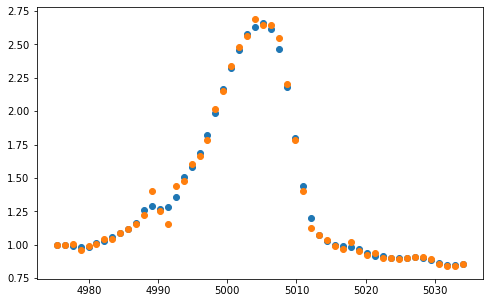

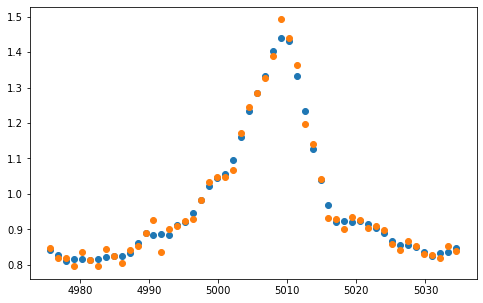

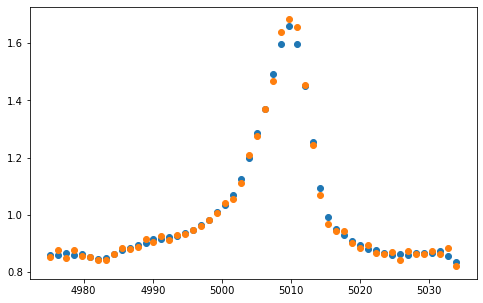

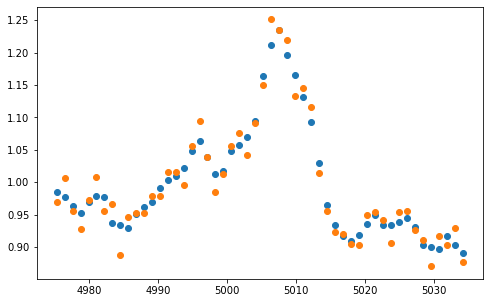

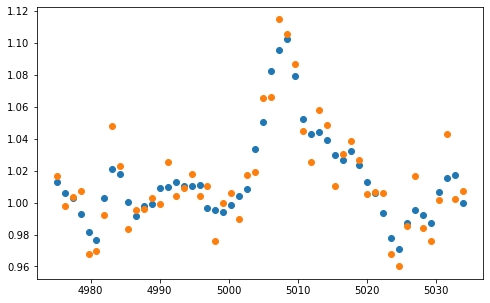

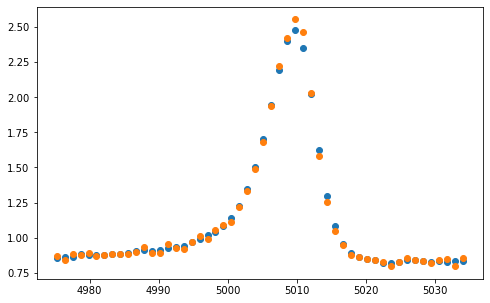

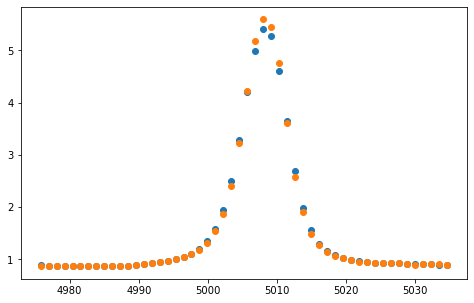

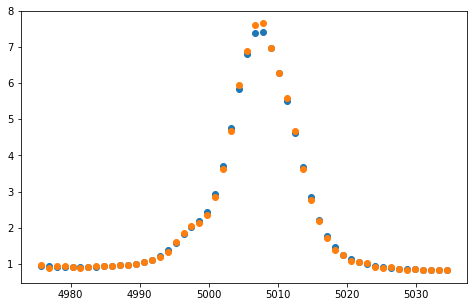

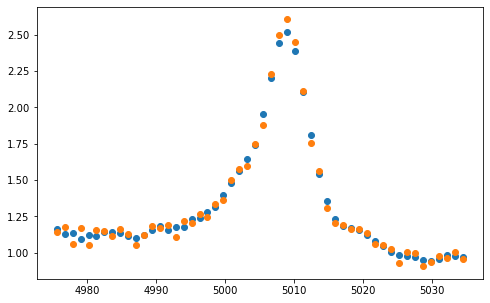

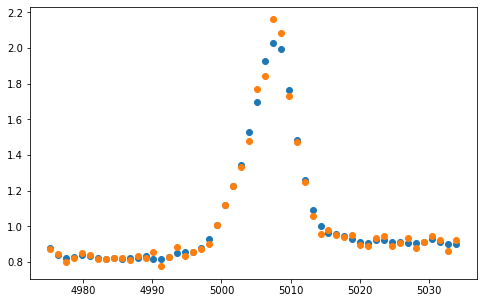

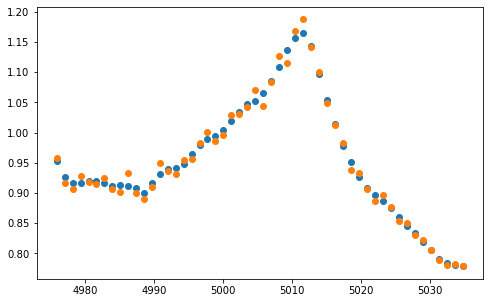

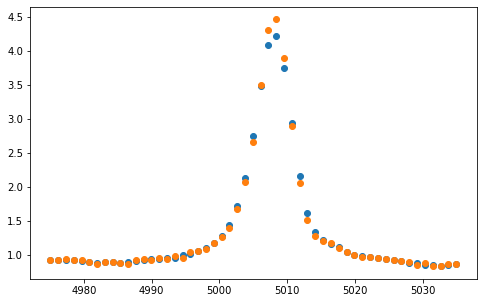

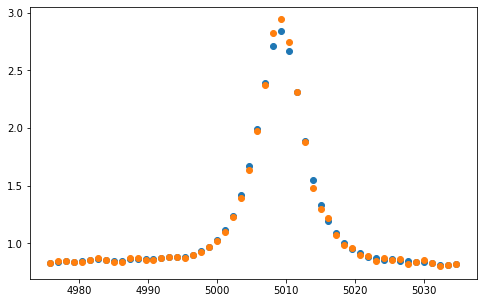

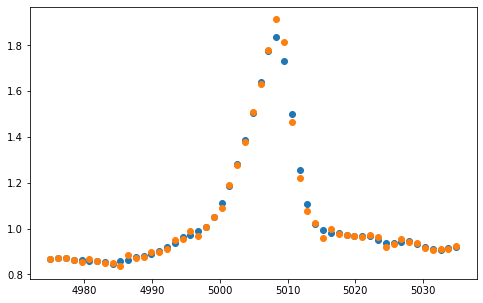

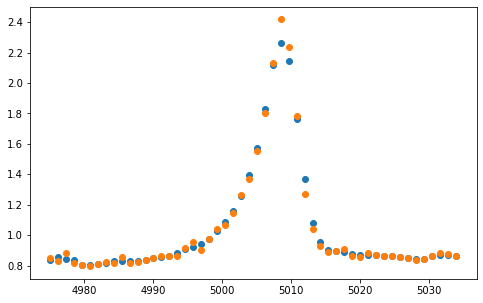

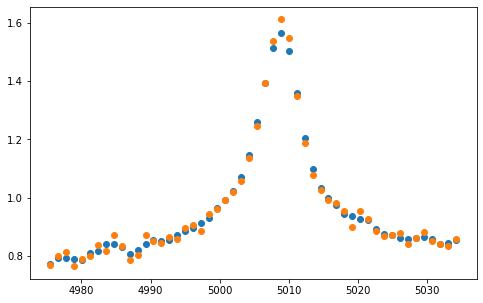

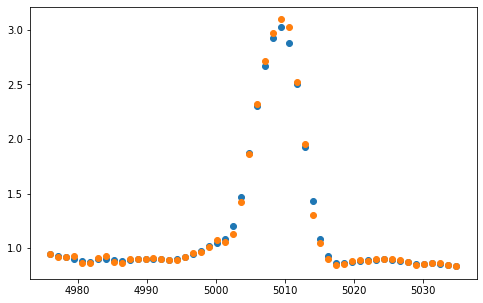

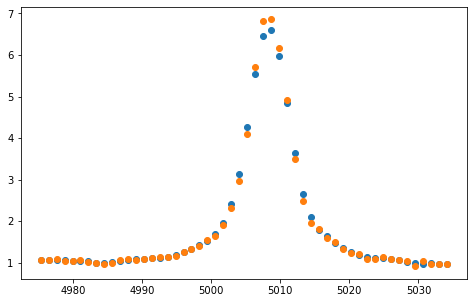

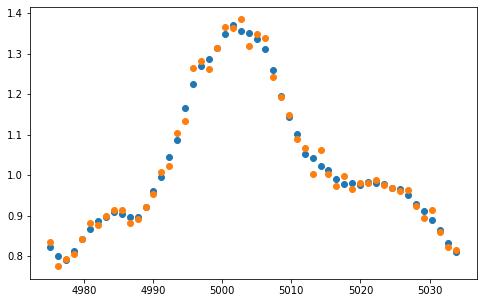

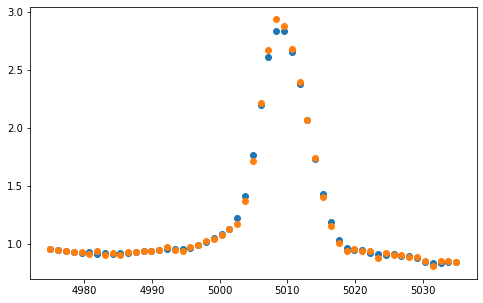

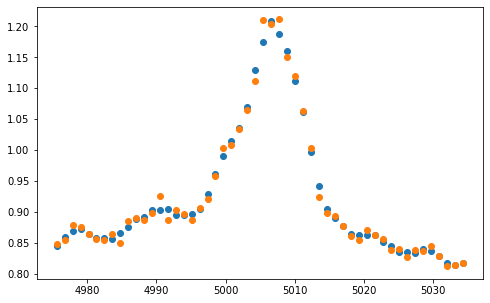

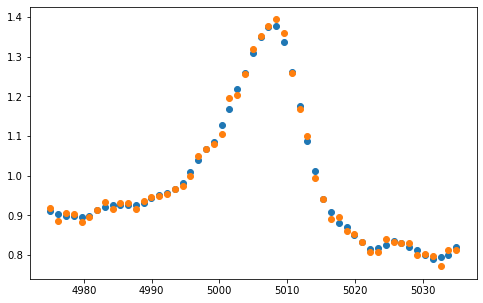

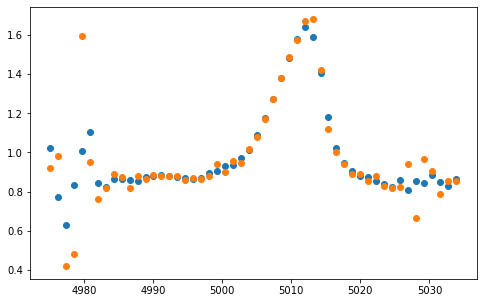

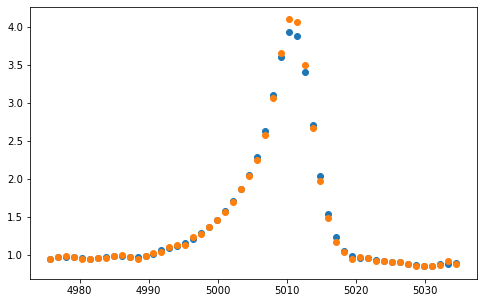

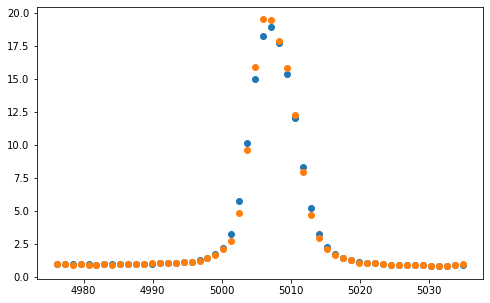

In [116]:
import scipy.signal
    
for i in range(25):
    hdul = fits.open("lite/%04d/spec-%04d-%d-%04d.fits" % (plate[i], plate[i], mjd[i], fiber[i]))

    f = hdul[1].data.field(0)
    flux = f/np.median(f)
    wave = 10.**hdul[1].data.field(1) / (1+z[i])
    flux = flux[(wave<5035)&(wave>4975)]
    wave = wave[(wave<5035)&(wave>4975)]
    
    plt.figure(figsize=(8, 5))
    plt.scatter(wave, scipy.signal.savgol_filter(flux, 3, 1))
    plt.scatter(wave, flux)
    plt.show()

Rejection method to turn spectra into histogram

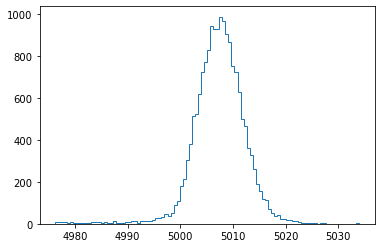

In [117]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def rejection(x, y):
    N=100000
    xlist = []
    ylist = []

    for i in range(N):
        xi = np.random.uniform(min(x), max(x), 1)
        yi = np.random.uniform(min(y), max(y), 1)
        if yi <= y[find_nearest(x, xi)]:
            xlist.append(xi)
            ylist.append(yi)
            
    return np.array(xlist), np.array(ylist)

xlist, ylist = rejection(wave, scipy.signal.savgol_filter(flux, 7, 1))
#plt.scatter(xlist, ylist)
plt.hist(xlist, histtype="step", bins=100)
plt.show()

In [123]:
gmm = GaussianMixture(n_components=2)
gmm.fit(xlist)
logprob = gmm.score_samples(wave.reshape(-1, 1))
responsibilities = gmm.predict_proba(wave.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

(array([0.00075168, 0.00075168, 0.00090202, 0.00052618, 0.00075168,
        0.00067652, 0.00052618, 0.00045101, 0.00030067, 0.00075168,
        0.00090202, 0.00075168, 0.00090202, 0.00045101, 0.00105236,
        0.00067652, 0.00045101, 0.00082685, 0.00097719, 0.00157854,
        0.00082685, 0.0014282 , 0.00135303, 0.0014282 , 0.00210472,
        0.00233022, 0.00330741, 0.00473561, 0.0042846 , 0.00826853,
        0.01330482, 0.01796526, 0.02976671, 0.04081647, 0.0505132 ,
        0.06201397, 0.07328924, 0.07885171, 0.0938854 , 0.09433641,
        0.09501292, 0.09719281, 0.08914979, 0.08403833, 0.07125969,
        0.0602851 , 0.05096421, 0.03562985, 0.03142041, 0.02360289,
        0.01510886, 0.01157594, 0.0097719 , 0.00556247, 0.00353292,
        0.00345775, 0.00195438, 0.00217989, 0.0014282 , 0.00090202,
        0.00090202, 0.00067652, 0.00015034, 0.00037584, 0.00045101,
        0.00022551, 0.00015034, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

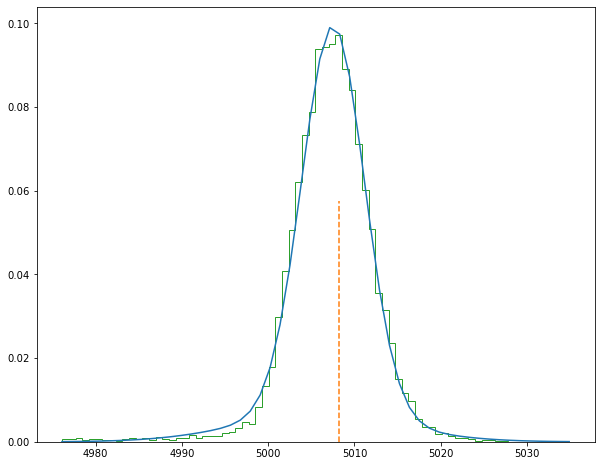

In [124]:
OIII = 5008.24
fig = plt.figure(figsize=(10,8))
plt.plot(wave, pdf)
plt.plot([OIII, OIII], [0.0, .0575], "--")
plt.hist(xlist, histtype="step", bins=75, density=True)
#plt.xlim(4925, 5040)
#plt.ylim(0.0, .0575)

In [149]:
def trapint(f, x, w=None):
    tot = 0
    for i in range(1, len(f)):
        tot += ((f[i-1] + f[i]) / 2) * (x[i] - x[i-1])
    
    #find x where w% of the flux accumulates
    if w is not None:
        if w==0.: return x[0]
        vsum = 0
        for j in range(1, len(f)):
            vsum += ((f[j-1] + f[j]) / 2) * (x[j] - x[j-1])
            if vsum/tot >= w:
                return x[j]
            
    return tot

def F(vrange, pdf, x): #compute CDF
    cdf = np.zeros(len(vrange))
    for i in range(len(vrange)):
        cdf[i] = trapint(pdf, x, vrange[i])
    return cdf

def blueshift(lamb):
    return ((lamb - OIII)/OIII) * 3.e5
        
    

trapint(pdf[(wave>4965)], v[(wave>4965)], 0.0)

-2339.5222

In [138]:
v[(wave>4965)]

array([-2339.5222 , -2270.8762 , -2202.406  , -2133.9067 , -2065.2021 ,
       -1996.6735 , -1927.9397 , -1859.3816 , -1790.6185 , -1722.0312 ,
       -1653.4147 , -1584.593  , -1515.9473 , -1447.1256 , -1378.4213 ,
       -1309.5704 , -1240.866  , -1172.1323 , -1103.2229 , -1034.4893 ,
        -965.52136,  -896.72906,  -827.7611 ,  -758.93964,  -690.11804,
        -621.0624 ,  -552.1823 ,  -483.15585,  -414.24652,  -345.1615 ,
        -276.25214,  -207.28426,  -138.14072,   -69.17281,     0.     ,
          68.99717,   138.19925,   207.25497,   276.3107 ,   345.54208,
         414.6563 ,   483.91696,   553.0605 ,   622.3504 ,   691.5232 ,
         760.69604,   830.0445 ,   899.2465 ,   968.62427,  1037.8849 ,
        1107.292  ,  1176.5819 ,  1245.8425 ,  1315.308  ,  1384.6271 ,
        1454.1221 ,  1523.4998 ,  1592.9945 ,  1662.3722 ,  1731.7793 ,
        1801.3619 ,  1870.7982 ,  1940.4102 ,  2009.8756 ,  2079.5168 ,
        2149.0117 ,  2218.5066 ,  2288.2063 ,  2357.7302 ,  2427

In [126]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

That's pretty good, but we'll want to convert the x-axis to velocity to interpret the CDF in terms of *velocity widths*.  Recall some physics:

$$ v = \frac{\Delta\lambda}{\lambda_0}c $$,

and we'll follow Zakamska & Greene and Coatman+2019, defining the peak of [O III] at to be $v = 0$ km/s.  The above equation now looks like:

$$ v = \frac{\lambda - \lambda[\mathrm{np.argmax(flux)}]}{\lambda[\mathrm{np.argmax(flux)]}}c $$,

and we can further define the blueshift of the [O III] line to be:

$$ v = \frac{\lambda[\mathrm{np.argmax(flux)}] - 5008.24Å}{5008.24Å}c $$

In [127]:
v = ((wave - wave[np.argmax(flux)]) / wave[np.argmax(flux)]) * 3.e5

In [128]:
np.linspace(0, 1, 21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [168]:
%%capture

Ng = 7 #number components in Gaussian fitting
w90 = []
blueshift = []

for i in range(len(name)):
    hdul = fits.open("lite/%04d/spec-%04d-%d-%04d.fits" % (plate[i], plate[i], mjd[i], fiber[i]))

    f = hdul[1].data.field(0)
    flux = f/np.median(f)
    wave = 10.**hdul[1].data.field(1) / (1+z[i])
    flux = flux[(wave<5050)&(wave>4925)]
    wave = wave[(wave<5050)&(wave>4925)]
    
    plt.figure(figsize=(8, 5))
    plt.scatter(wave, scipy.signal.savgol_filter(flux, 5, 1), label="filtered flux")
    plt.scatter(wave, flux, label="raw SDSS flux")
    plt.title("%s Spectrum with Savitsky-Golay Filter applied" % (name[i]))
    plt.ylabel("wavelength (Å)")
    plt.ylabel("flux")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("OIII_spectra/raw/%s.png" % (name[i]))
    plt.show()
    
    
    #Now worried about the velocity profile, so change from Å to km/s
    v = ((wave - wave[np.argmax(flux)]) / wave[np.argmax(flux)]) * 3.e5
    
    #Use rejection method to turn to PDF
    xlist, ylist = rejection(v, scipy.signal.savgol_filter(flux, 5, 1))
    #plt.scatter(xlist, ylist)
    vcounts, bins, patches = plt.hist(xlist, histtype="step", bins=100)
    plt.title("%s Histogram from Rejection Method" % (name[i]))
    plt.xlabel("velocity offset from [O III] (km s$^{-1}$)")
    plt.tight_layout()
    plt.savefig("OIII_spectra/histograms/%s.png" % (name[i]))
    plt.show()
    
    
    #Use GMM to get noiseless reconstruction of spectrum -- we're basically treating it as a PDF
    gmm = GaussianMixture(n_components=Ng)
    gmm.fit(xlist)
    logprob = gmm.score_samples(v.reshape(-1, 1))
    responsibilities = gmm.predict_proba(v.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    plt.plot(v, pdf, label="GMM fit")
    plt.plot([0.0, 0.0], [0.0, max(pdf)+0.05*max(pdf)], "--", label="laboratory wavelength")
    plt.hist(xlist, histtype="step", bins=100, density=True, label="spectrum")    
    
    #Compute velocity widths and blueshifts
    vrange = np.linspace(0, 1, 21) #Compute CDF at these values to turn into velocity widths from differences
    F_vv = F(vrange, pdf[(wave>4975)], v[(wave>4975)]) 
    v05 = F_vv[find_nearest(vrange, 0.05)]
    v95 = F_vv[find_nearest(vrange, 0.95)]
    w90.append(v95-v05)
    voff = v[np.argmax(pdf)]
    plt.plot([voff,voff], [0.0, max(pdf)+0.05*max(pdf)], label="peak offset")
    blueshift.append(voff)
    
    plt.xlim(min(v), max(v))
    plt.ylim(0.0, max(pdf)+0.05*max(pdf))
    plt.xlabel("velocity offset from [O III] (km s$^{-1}$)")
    plt.ylabel("flux")
    plt.title(name[i])
    plt.legend(loc="best", prop={"size":11})
    plt.tight_layout()
    plt.savefig("OIII_spectra/gmm/%s.png" % (name[i]))
    plt.show()

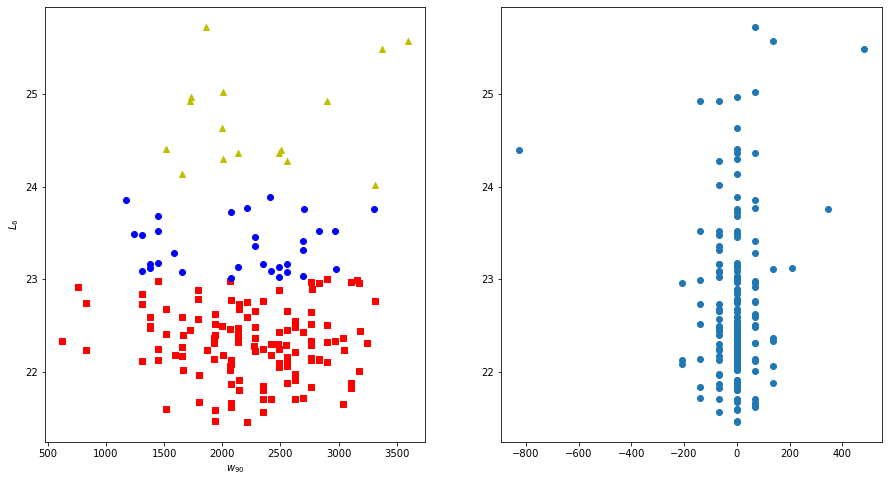

In [174]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,8))

w90 = np.array(w90)
ax1.scatter(w90[RQ], L6[RQ], marker="s", color="r", label="radio-quiet")
ax1.scatter(w90[RI], L6[RI], marker="o", color="b", label="radio-intermediate")
ax1.scatter(w90[RL], L6[RL], marker="^", color="y", label="radio-loud")
ax1.set_xlabel("$w_{90}$")
ax1.set_ylabel("$L_6$")

ax2.scatter(blueshift, L6)
plt.show()

In [166]:
w90

[]

In [84]:
total_cdf = trapint(pdf, v)
vrange = np.linspace(0, total_cdf, 21) #Compute CDF at these values to turn into velocity widths from differences
F_vv = F(vrange, pdf, v) 
print(F_vv)

[    0.         -3979.88110352 -3434.16821289 -3092.54882812
 -2887.25488281 -2613.6081543  -2270.8762207  -1515.94726562
  -965.5213623   -621.06237793  -414.246521    -345.16149902
  -207.28425598   -69.17281342     0.            68.99716949
   138.19924927   276.31069946   345.54208374   622.35040283
  1940.41015625]
